In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    recall_score, f1_score, precision_score, roc_auc_score
)
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
import seaborn as sns

# Global reproducibility seed
RANDOM_STATE = 42

# Plot style (for heatmaps etc.)
sns.set(style="whitegrid", font_scale=1.1)

In [3]:
# ============================================================
# 1. Load raw dataset, encode categorical features, split data
# ============================================================

df = pd.read_csv("/Users/hwangsia/final_data.csv")

print("Original shape:", df.shape)
print(df.head())

y = df["COPD"]
X_raw = df.drop(columns=["COPD", "ID"])

# we'll decode later in cell 6 using these
orig_feature_names = list(X_raw.columns)

# treat EVERYTHING as categorical
X_raw = X_raw.astype(str)

# one-hot encode (keep ALL levels so we can decode perfectly later)
X_encoded = pd.get_dummies(X_raw, drop_first=False)

print("After one-hot encoding shape:", X_encoded.shape)
print(X_encoded.head())

# map each original var -> its dummy columns (for decoding later)
dummy_map = {
    var: [c for c in X_encoded.columns if c.startswith(var + "_")]
    for var in orig_feature_names
}

# train/test split BEFORE any scaling/oversampling
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y,
    test_size=0.2,
    stratify=y,
    random_state=RANDOM_STATE
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)
print("Train COPD distribution:\n", y_train.value_counts())
print("Test COPD distribution:\n", y_test.value_counts())


Original shape: (2776, 11)
                ID  COPD  age     sex OccupationRisk Income         smoking  \
0  CODA24L27862226     0  50s    Male    Non–at-risk   High   Former Smoker   
1  CODA24L31534447     0  50s    Male        At-risk   High  Current Smoker   
2  CODA24L47263638     0  50s    Male    Non–at-risk    Low      Non-smoker   
3  CODA24L14080640     0  50s  Female    Non–at-risk   High      Non-smoker   
4  CODA24L76507177     1  50s    Male    Non–at-risk   High   Former Smoker   

  Packyears Asthma BMI_Group PM25_Group  
0       low     No     Obese       high  
1       low     No    Normal        low  
2       NaN     No     Obese       high  
3       NaN     No    Normal       high  
4       low     No    Normal        low  
After one-hot encoding shape: (2776, 24)
   age_50s  age_60s  age_70+  sex_Female  sex_Male  OccupationRisk_At-risk  \
0     True    False    False       False      True                   False   
1     True    False    False       False      Tru

In [4]:
# =====================================================================
# 2. Stratified 10-fold CV grid search over ADASYN params (r, k)
#
# For each (r, k):
#   - Within each CV fold:
#       scale(train_fold)
#       ADASYN(train_fold_scaled)
#       train logistic regression
#       eval on val_fold_scaled (no oversampling in val)
#
# We collect mean/std of Recall and F1.
#
# Outputs:
#   grid_df  : full results (Appendix-style table)
#   grid_top : top rows (Table 3-style summary)
# =====================================================================

# ADASYN hyperparameter grid
r_values = [round(v, 2) for v in np.arange(0.20, 1.01, 0.10)]   # 0.20 ... 1.00
k_values = [3, 5, 7, 9, 11, 13, 15]                             # neighborhood sizes

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)

grid_records = []

for r in r_values:
    for k in k_values:

        fold_recalls = []
        fold_f1s = []

        # 10-fold CV on training data only
        for train_idx, val_idx in cv.split(X_train, y_train):
            # fold split
            X_tr_fold = X_train.iloc[train_idx].copy()
            y_tr_fold = y_train.iloc[train_idx].copy()
            X_val_fold = X_train.iloc[val_idx].copy()
            y_val_fold = y_train.iloc[val_idx].copy()

            # scale on fold-train only
            scaler = StandardScaler()
            X_tr_fold_scaled = scaler.fit_transform(X_tr_fold)
            X_val_fold_scaled = scaler.transform(X_val_fold)

            # oversample only the fold-train portion
            ada = ADASYN(
                sampling_strategy=r,
                n_neighbors=k,
                random_state=RANDOM_STATE
            )
            X_tr_fold_res, y_tr_fold_res = ada.fit_resample(X_tr_fold_scaled, y_tr_fold)

            # train logistic regression on oversampled fold-train
            clf = LogisticRegression(
                random_state=RANDOM_STATE,
                max_iter=1000
            )
            clf.fit(X_tr_fold_res, y_tr_fold_res)

            # evaluate on untouched fold-val
            y_val_pred = clf.predict(X_val_fold_scaled)

            # collect metrics (threshold = 0.5)
            fold_recalls.append(recall_score(y_val_fold, y_val_pred))
            fold_f1s.append(f1_score(y_val_fold, y_val_pred))

        mean_recall = float(np.mean(fold_recalls))
        std_recall  = float(np.std(fold_recalls, ddof=1))
        mean_f1     = float(np.mean(fold_f1s))
        std_f1      = float(np.std(fold_f1s, ddof=1))

        grid_records.append({
            "r": r,
            "k": k,
            "mean_recall": round(mean_recall, 4),
            "std_recall": round(std_recall, 4),
            "mean_f1": round(mean_f1, 4),
            "std_f1": round(std_f1, 4)
        })

grid_df = pd.DataFrame(grid_records)

grid_top = (
    grid_df
    .sort_values(by=["mean_recall", "std_recall"], ascending=[False, True])
    .head(5)
)

print("\n=== Full Grid Search results (preview) ===")
print(grid_df.head())
print("\n=== Top-performing ADASYN settings (for main text) ===")
print(grid_top)

grid_df.to_csv("/Users/hwangsia/ADASYN_grid_full.csv", index=False)
grid_top.to_csv("/Users/hwangsia/ADASYN_grid_top.csv", index=False)


=== Full Grid Search results (preview) ===
     r   k  mean_recall  std_recall  mean_f1  std_f1
0  0.2   3       0.0694      0.0406   0.1212  0.0657
1  0.2   5       0.0474      0.0301   0.0855  0.0526
2  0.2   7       0.0476      0.0304   0.0863  0.0528
3  0.2   9       0.0402      0.0366   0.0728  0.0646
4  0.2  11       0.0327      0.0204   0.0607  0.0380

=== Top-performing ADASYN settings (for main text) ===
      r   k  mean_recall  std_recall  mean_f1  std_f1
62  1.0  15       0.6794      0.0675   0.3204  0.0198
59  1.0   9       0.6791      0.0620   0.3199  0.0205
60  1.0  11       0.6720      0.0664   0.3169  0.0244
61  1.0  13       0.6718      0.0715   0.3167  0.0239
58  1.0   7       0.6644      0.0602   0.3140  0.0228


In [5]:
# =============================================================================
# 3. Pick best (r, k) by mean_recall.
#    Then oversample the ENTIRE training set with that ADASYN setting.
#
# We:
#   - fit scaler on full training set
#   - run ADASYN(best_r,best_k) on scaled training
#   - summarize class counts before/after
#
# Output:
#   table4_df : class balance table (Table 4-style)
# =============================================================================

best_row = grid_df.sort_values(by="mean_recall", ascending=False).iloc[0]
best_r = float(best_row["r"])
best_k = int(best_row["k"])

print("\nChosen best ADASYN hyperparameters (r, k):", best_r, best_k)

scaler_full = StandardScaler()
X_train_scaled_full = scaler_full.fit_transform(X_train)

ada_best = ADASYN(
    sampling_strategy=best_r,
    n_neighbors=best_k,
    random_state=RANDOM_STATE
)
X_train_aug, y_train_aug = ada_best.fit_resample(X_train_scaled_full, y_train)

orig_counts = y_train.value_counts().sort_index()          # {0: n0, 1: n1}
aug_counts  = pd.Series(y_train_aug).value_counts().sort_index()

orig_ratio = round(orig_counts[0] / orig_counts[1], 2)
aug_ratio  = round(aug_counts[0]  / aug_counts[1] , 2)

table4_df = pd.DataFrame({
    "Dataset": ["Original Train", f"ADASYN (r={best_r}, k={best_k})"],
    "Neg(0)":  [int(orig_counts[0]), int(aug_counts[0])],
    "Pos(1)":  [int(orig_counts[1]), int(aug_counts[1])],
    "Ratio":   [
        f"{orig_counts[0]} : {orig_counts[1]} ({orig_ratio}:1)",
        f"{aug_counts[0]} : {aug_counts[1]} ({aug_ratio}:1)"
    ]
})

print("\n=== Table 4: Class distribution before vs after ADASYN ===")
print(table4_df)

table4_df.to_csv("/Users/hwangsia/ADASYN_table4_class_balance.csv", index=False)


Chosen best ADASYN hyperparameters (r, k): 1.0 15

=== Table 4: Class distribution before vs after ADASYN ===
                Dataset  Neg(0)  Pos(1)                Ratio
0        Original Train    1946     274   1946 : 274 (7.1:1)
1  ADASYN (r=1.0, k=15)    1946    1943  1946 : 1943 (1.0:1)


In [6]:
# =============================================================================
# 4. Final model comparison on held-out test set
#
# Train:
#   A) LogisticRegression on original (scaled) train
#   B) LogisticRegression on ADASYN-augmented train
#
# Test:
#   same untouched X_test, scaled with scaler_full
#
# Output:
#   table5_df : performance table (Table 5-style)
# =============================================================================

X_test_scaled_full = scaler_full.transform(X_test)

# (A) original imbalanced train
clf_orig = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
clf_orig.fit(X_train_scaled_full, y_train)

y_pred_orig = clf_orig.predict(X_test_scaled_full)  # threshold 0.5
y_prob_orig = clf_orig.predict_proba(X_test_scaled_full)[:, 1]

orig_f1   = f1_score(y_test, y_pred_orig)
orig_rec  = recall_score(y_test, y_pred_orig)
orig_prec = precision_score(y_test, y_pred_orig, zero_division=0)
orig_auc  = roc_auc_score(y_test, y_prob_orig)

# (B) ADASYN-augmented train
clf_aug = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
clf_aug.fit(X_train_aug, y_train_aug)

y_pred_aug = clf_aug.predict(X_test_scaled_full)    # threshold 0.5
y_prob_aug = clf_aug.predict_proba(X_test_scaled_full)[:, 1]

aug_f1   = f1_score(y_test, y_pred_aug)
aug_rec  = recall_score(y_test, y_pred_aug)
aug_prec = precision_score(y_test, y_pred_aug, zero_division=0)
aug_auc  = roc_auc_score(y_test, y_prob_aug)

table5_df = pd.DataFrame({
    "Training Dataset": ["Original Train", "ADASYN Augmented Train"],
    "F1 Score":  [round(orig_f1, 4),  round(aug_f1, 4)],
    "Recall":    [round(orig_rec, 4), round(aug_rec, 4)],
    "Precision": [round(orig_prec,4), round(aug_prec,4)],
    "AUC-ROC":   [round(orig_auc,4),  round(aug_auc,4)]
})

print("\n=== Table 5: Performance comparison (original vs ADASYN) ===")
print(table5_df)

table5_df.to_csv("/Users/hwangsia/ADASYN_table5_performance.csv", index=False)

# %%


=== Table 5: Performance comparison (original vs ADASYN) ===
         Training Dataset  F1 Score  Recall  Precision  AUC-ROC
0          Original Train    0.0548  0.0294     0.4000   0.7163
1  ADASYN Augmented Train    0.3245  0.6324     0.2183   0.7077


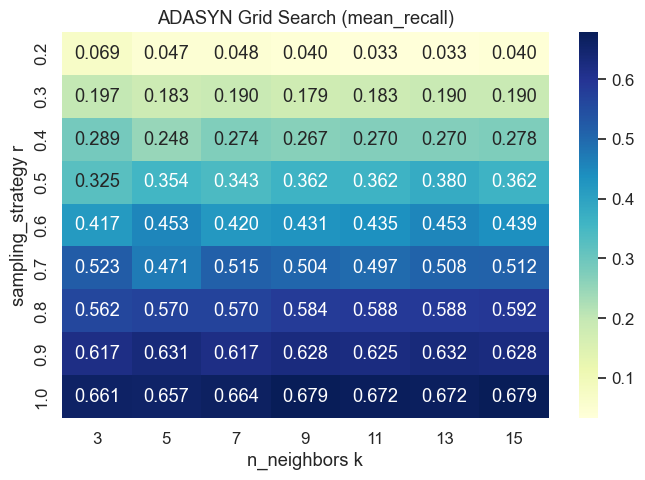

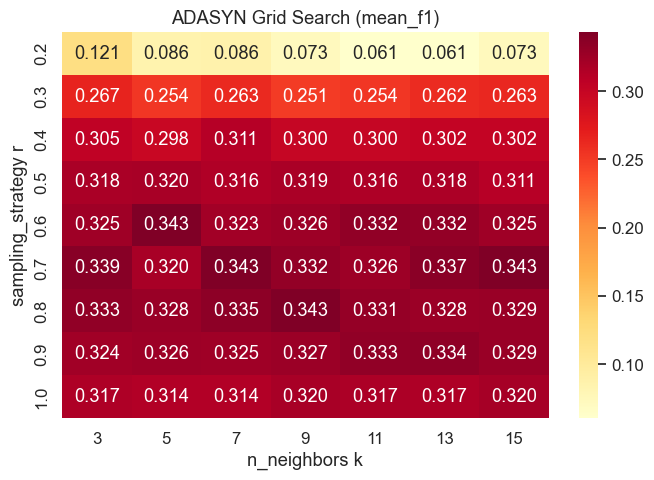

In [7]:
# =============================================================================
# 5. Visualization: heatmaps of mean_recall and mean_f1 across (r,k)
#
# Outputs:
#   ADASYN_heatmap_mean_recall.png
#   ADASYN_heatmap_mean_f1.png
# =============================================================================

pivot_recall = grid_df.pivot_table(index="r", columns="k", values="mean_recall")
pivot_f1     = grid_df.pivot_table(index="r", columns="k", values="mean_f1")

plt.figure(figsize=(7,5))
sns.heatmap(pivot_recall, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title("ADASYN Grid Search (mean_recall)")
plt.ylabel("sampling_strategy r")
plt.xlabel("n_neighbors k")
plt.tight_layout()
plt.savefig("/Users/hwangsia/ADASYN_heatmap_mean_recall.png", dpi=300)
plt.show()

plt.figure(figsize=(7,5))
sns.heatmap(pivot_f1, annot=True, fmt=".3f", cmap="YlOrRd")
plt.title("ADASYN Grid Search (mean_f1)")
plt.ylabel("sampling_strategy r")
plt.xlabel("n_neighbors k")
plt.tight_layout()
plt.savefig("/Users/hwangsia/ADASYN_heatmap_mean_f1.png", dpi=300)
plt.show()



In [8]:
# =============================================================================
# 6. Export BN-ready oversampled training data (categorical decoded)
# =============================================================================

adasyn_aug_df = pd.DataFrame(X_train_aug, columns=X_train.columns)
adasyn_aug_df["COPD"] = y_train_aug.values

print("\nADASYN-augmented (numeric) shape:", adasyn_aug_df.shape)

decoded_rows = []

for row_i in range(len(adasyn_aug_df)):
    row = adasyn_aug_df.iloc[row_i]

    decoded_record = {}

    # decode each original categorical variable
    for var in orig_feature_names:
        # all dummy cols for this var
        cols_for_var = dummy_map[var]

        # grab values for those dummy cols in this row
        vals = row[cols_for_var].values.astype(float)

        # pick the dummy column with the highest value
        winner_idx = int(np.argmax(vals))
        winner_col = cols_for_var[winner_idx]

        # dummy col name looks like "<var>_<level>"
        level_name = winner_col.split(var + "_", 1)[1]

        decoded_record[var] = level_name

    # add target
    decoded_record["COPD"] = int(row["COPD"])

    decoded_rows.append(decoded_record)

decoded_df = pd.DataFrame(decoded_rows)

print("\nDecoded categorical (BN-ready) shape:", decoded_df.shape)
print(decoded_df.head())

decoded_df.to_csv("/Users/hwangsia/adasyn_data_decoded.csv", index=False)

print("\nSaved BN-ready oversampled dataset -> adasyn_data_decoded.csv")



ADASYN-augmented (numeric) shape: (3889, 25)

Decoded categorical (BN-ready) shape: (3889, 10)
   age     sex OccupationRisk Income        smoking Packyears Asthma  \
0  60s    Male    Non–at-risk   High  Former Smoker       low     No   
1  50s    Male        At-risk    Low  Former Smoker       low     No   
2  60s    Male    Non–at-risk   High  Former Smoker       low     No   
3  50s  Female    Non–at-risk   High     Non-smoker       nan     No   
4  50s  Female    Non–at-risk    Low     Non-smoker       nan     No   

  BMI_Group PM25_Group  COPD  
0     Obese       high     0  
1    Normal        low     0  
2     Obese       high     1  
3     Obese       high     0  
4     Obese        low     0  

Saved BN-ready oversampled dataset -> adasyn_data_decoded.csv
